# Table of contents
1. [Introduction](#introduction)
2. [Import](#import)
3. [Data preprocessing](#preprocess)
    1. [Missing values](#subpreprocess)
4. [Correlation with dependent variable](#correlation_dependent)
5. [Feature engineering](#feature_engineering)
    1. [One-hot encoding](#one-hot)
6. [Importance of variables](#importance)
    1. [Correlation between variables with highest importance score](#correlation_importance)
    2. [Variables selection](#variables_selection)
7. [Scaling data](#scaling)
8. [Train-test split](#train_test)
9. [Base estimator - linear regression](#base_estimator)
10. [Xgboost](#xgboost)

## This is the introduction <a name="introduction"></a>

## Importing packages and data <a name="import"></a>

In [1]:
import pandas as pd
import numpy as np
import os
import scipy as sp
import matplotlib
matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings
from utils import plot_learning_curve
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pickle
from utils import plot_learning_curve

Changing the fontisize for all graphs so that everything is (hopefully) clearly visible

In [3]:
font = {'size'   : 15}

matplotlib.rc('font', **font)

In [4]:
data_house = pd.read_csv('train.csv')

## Data preprocessing <a name="preprocess"></a>
The first paragraph text

### Missing values <a name="subpreprocess"></a>
This is a sub paragraph, formatted in heading 3 style

Check on the missing values

In [5]:
missing = data_house.isnull().sum().sort_values(ascending=False)
percent = data_house.isnull().sum()/data_house.isnull().count().sort_values(ascending=False)
data_missing = pd.concat([missing, percent], axis=1, keys=['Total', 'Percent']).sort_values(by='Total', ascending=False)
print(data_missing.head(6))

             Total   Percent
PoolQC        1453  0.995205
MiscFeature   1406  0.963014
Alley         1369  0.937671
Fence         1179  0.807534
FireplaceQu    690  0.472603
LotFrontage    259  0.177397


Plot missing variables in descending order, results are shown only for those variables that do possess some NaNs

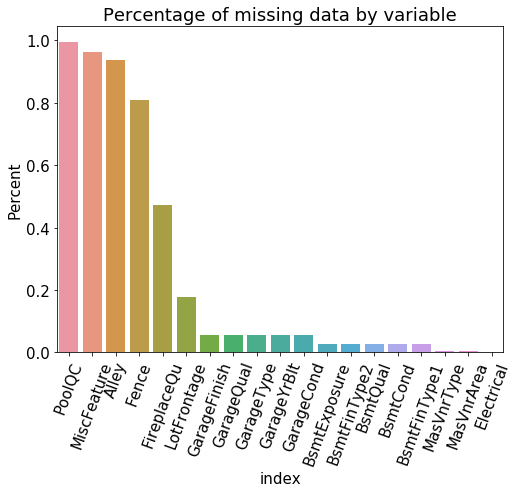

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
sns.barplot(data=data_missing[data_missing['Percent'] >0].reset_index(), x = 'index', 
            y='Percent')
plt.xticks(rotation=70)
plt.title("Percentage of missing data by variable")
plt.show()

Drop variables when more than 90% of data is missing

In [7]:
data_house.drop(data_missing[data_missing['Percent']>0.7].index,1, inplace=True)

Based on description file.txt most of the missing data in variables such as Fence, Garage or Bsmt connected variables
are due to the lack of fence, garage etc. Due ot this fact we can fill NA in those variables with new category (since they are categorical variables)
For the data that is numeric the filled values are equal to zero - also due to the fact that apparent absence of values of these variables is connected with missing data

In [8]:
data_house.loc[:,data_house.columns.str.contains
("Garage|Bsmt|Fence|MasVnrType|Electrical|FireplaceQu")] =data_house.loc[:,
data_house.columns.str.contains("Garage|Bsmt|Fence|MasVnrType|Electrical|FireplaceQu")].fillna("MISSING")
data_house.loc[:,["MasVnrArea", "LotFrontage"]] = data_house.loc[:,["MasVnrArea", "LotFrontage"]].fillna(0)

Distribution of the target variable

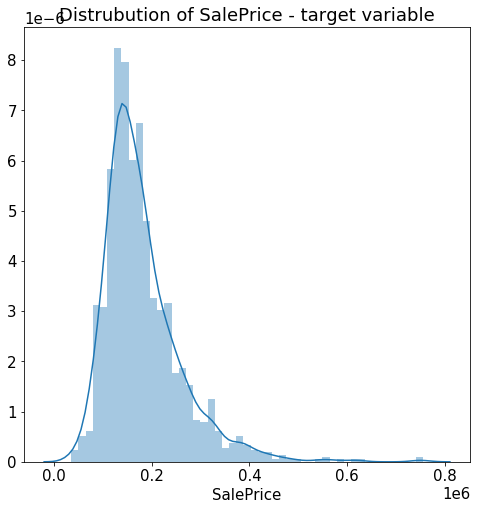

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [9]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(data_house['SalePrice'])
ax.set_title("Distrubution of SalePrice - target variable")
ax.ticklabel_format(style='scientific', axis='both', scilimits=(-3,3))
plt.show()
skew = data_house['SalePrice'].skew()
kurt = data_house['SalePrice'].kurt()
print(f'Skewness: {skew}\nKurtosis: {kurt}')

Fiew visualisations to show basic relationships and statistics

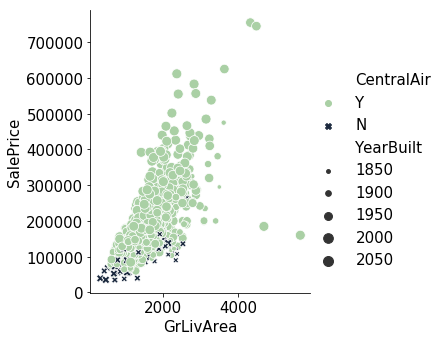

In [10]:
sns.relplot(x = 'GrLivArea', y = 'SalePrice', hue = 'CentralAir', style='CentralAir', 
            palette= "ch:r=-.5,l=0.75", size="YearBuilt", sizes=(15,100), data = data_house)
plt.show()

We can see that there are outliers present, with GrLivArea higher than 4000 square feet
<br>
They can be removed without further ado


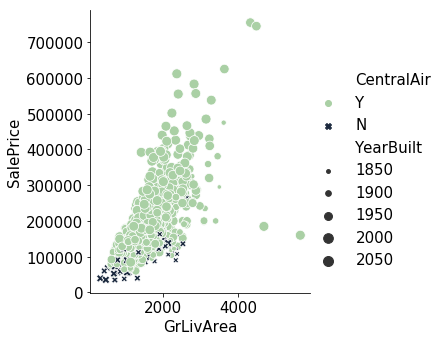

In [11]:
sns.relplot(x = 'GrLivArea', y = 'SalePrice', hue = 'CentralAir', style='CentralAir', 
            palette= "ch:r=-.5,l=0.75", size="YearBuilt", sizes=(15,100), data = data_house)
plt.show()

In [12]:
data_house = data_house[data_house['GrLivArea'] <4000]

Show average SalePrice by year

In [13]:
data_mean = data_house.groupby(by='YearBuilt').agg('mean')
data_mean.reset_index(inplace=True)

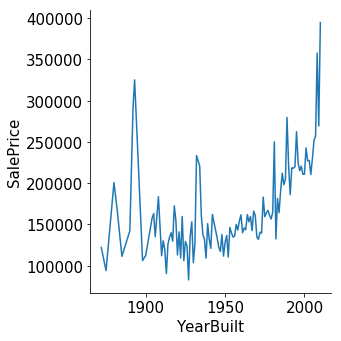

In [14]:
sns.relplot(x='YearBuilt', y = 'SalePrice', kind='line', data=data_mean)
plt.show()

Show the same data but this time with standard deviation

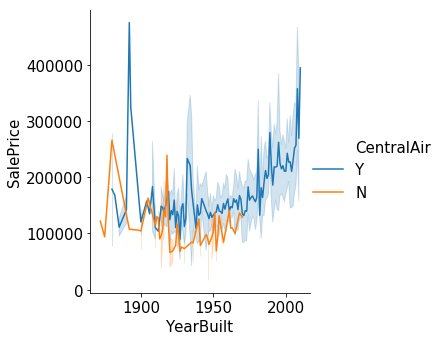

In [15]:
g = sns.relplot(x='YearBuilt', y = 'SalePrice', kind='line', ci='sd', estimator = 'mean',
            hue = 'CentralAir',data=data_house)
plt.show()

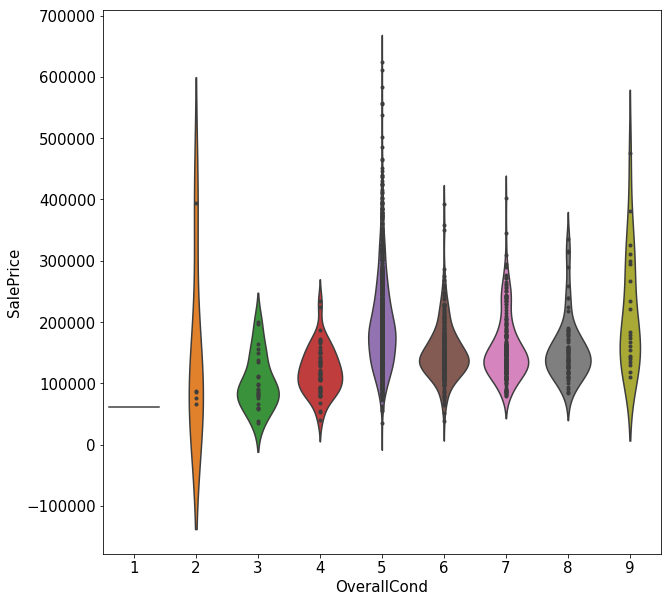

In [16]:
fig, ax = plt.subplots(figsize = (10,10))
sns.violinplot(data=data_house, y='SalePrice', x='OverallCond', ax=ax, inner='points')
plt.show()

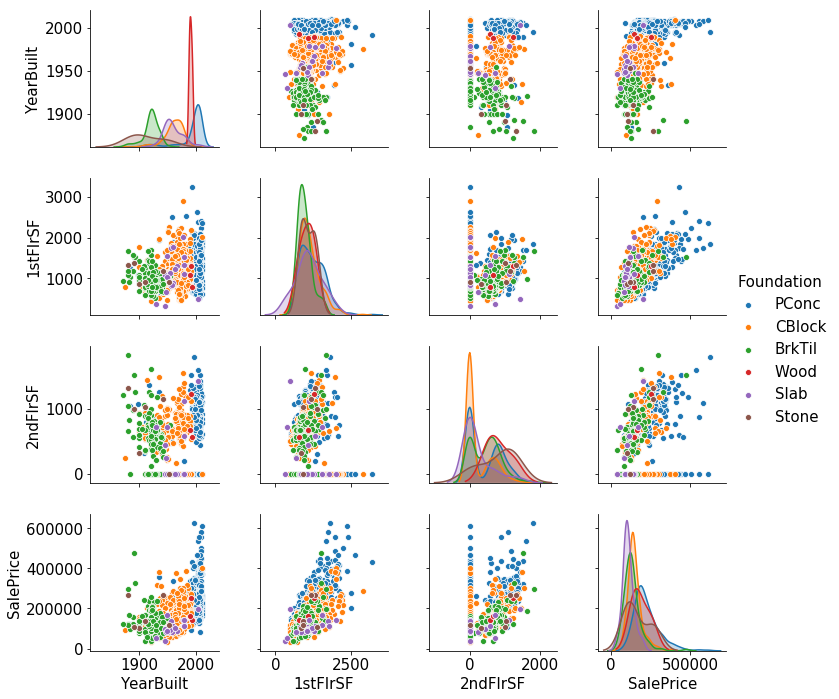

In [17]:
sns.pairplot(data=data_house, x_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'],
             y_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'], hue='Foundation')
plt.show()

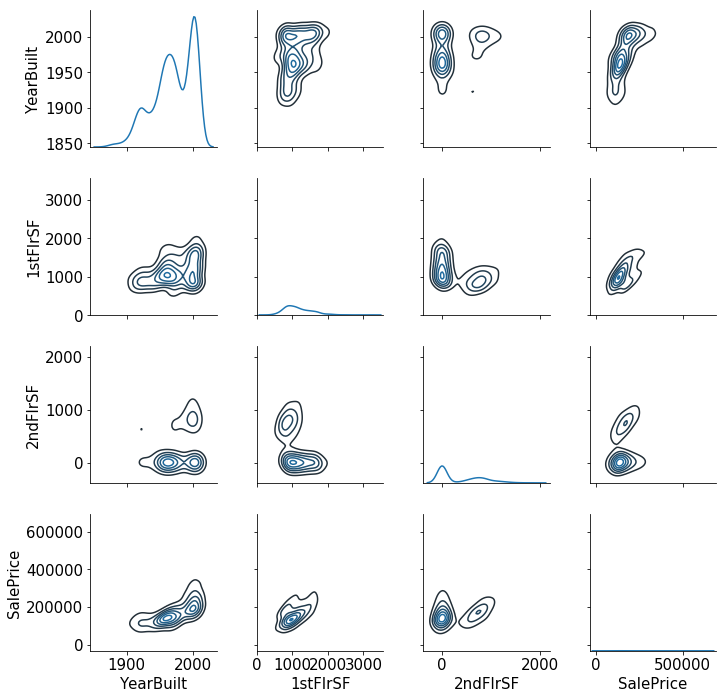

In [18]:
g = sns.PairGrid(data_house,x_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'],
             y_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

One can easily spot changes in the type of materials used to build houses throughout given time period.

Now it's time to check correlations between dependent variable and the rest

### Correlation with dependent variable <a name="correlation_dependent"></a>

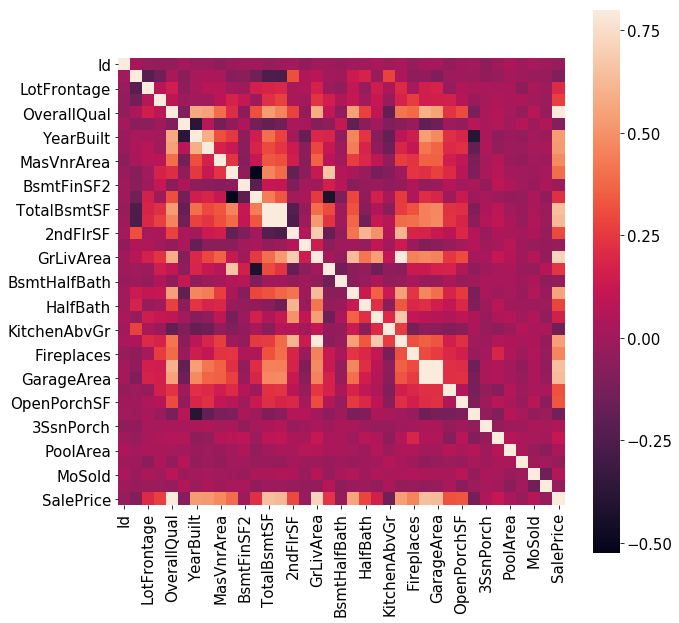

In [19]:
corrmat = data_house.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corrmat, vmax=.8, square=True)
plt.show()

Print only 10 mostly correlated variables

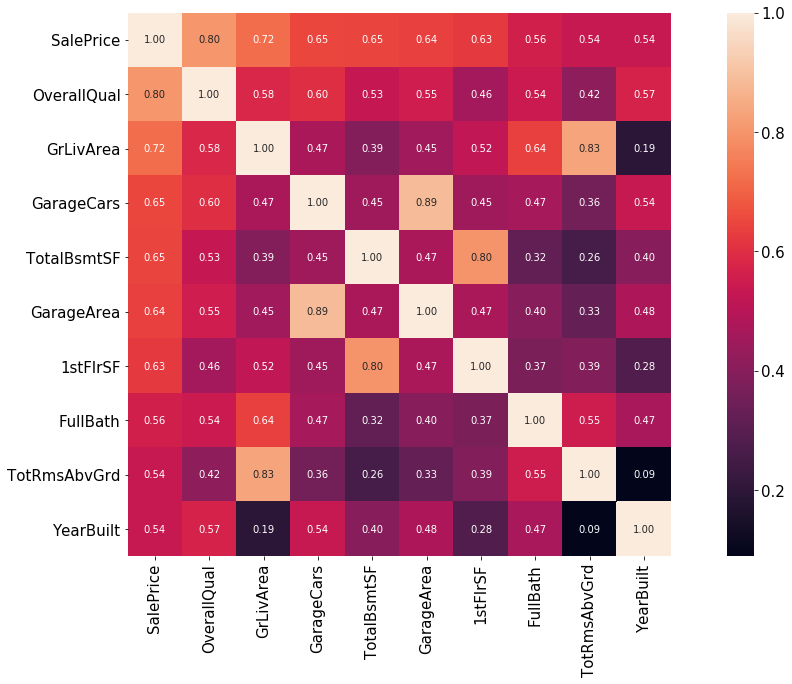

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
corr10 = data_house.loc[:, cols].corr()
sns.heatmap(data=corr10, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

### Feature engineering <a name="feature_engineering"></a>

It's reasonable to define Age variable instead of YearBuilt, since during scaling year differences
<br>
would be insignificant compared to differences in house ages
<br>
since the newest records are from year 2010, I'm going to assume that the dataset is from 2011 and based on that 
calculate the Age variable

In [21]:
data_house['Age'] = 2011 - data_house['YearBuilt']

### One-hot encoding <a name="one-hot"></a>

One-hot encoding of the character variables
<br>
Semicolon added to surpress output

In [22]:
pd.get_dummies(data_house.select_dtypes('object'));
data_house_one_hot = pd.concat([data_house.select_dtypes(['int','float']),
                                pd.get_dummies(data_house.select_dtypes('object'))], axis=1)

### Importance of variables <a name="importance"></a>

Importance selection based on RandomForest result and one-hot encoded data

In [23]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)

In [24]:
X_rf = data_house_one_hot.columns.isin(["SalePrice","Id"])
rf.fit(X=data_house_one_hot.loc[:, ~X_rf], 
       y = data_house_one_hot.loc[:,"SalePrice"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [25]:
importances = pd.concat([pd.Series(data_house_one_hot.columns[~X_rf]),
                         pd.Series(rf.feature_importances_)], axis=1)

In [26]:
importances_dict = dict(zip(data_house_one_hot.columns[~X_rf],rf.feature_importances_))

In [27]:
importances.columns = ['Feature', "Importance"]
importances_sorted = importances.sort_values(by="Importance",ascending=False)

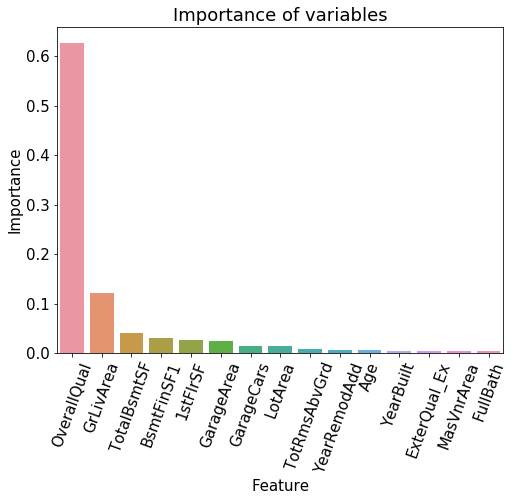

In [28]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
sns.barplot(data=importances_sorted.iloc[:15,:],
            x = "Feature",
            y='Importance')
plt.xticks(rotation=70)
plt.title("Importance of variables")
plt.show()

Calculate correlation matrix between 15 variables with highest importance from randomforest

### Correlation between variables with highest importance score <a name="correlation_importance"></a>

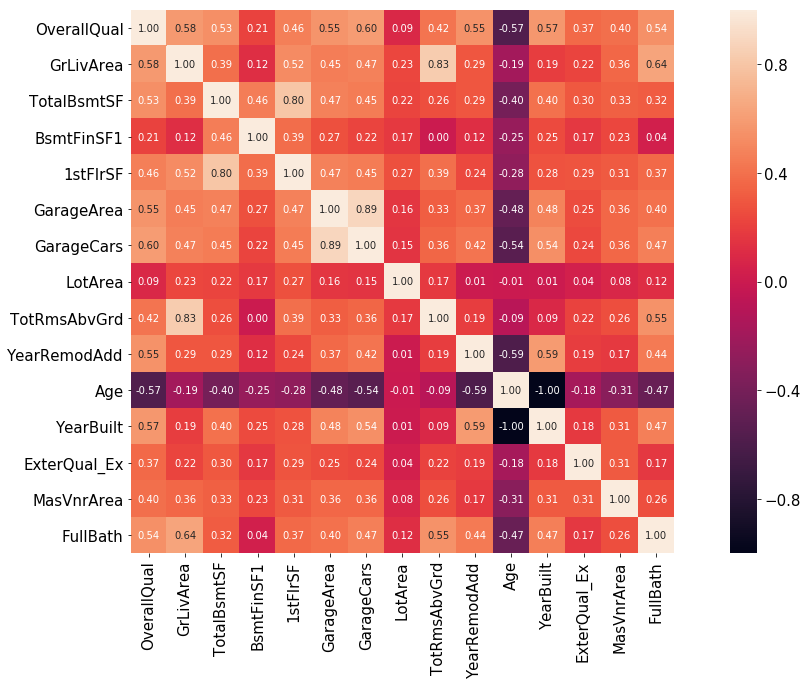

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
correlations = data_house_one_hot.loc[:,importances_sorted.iloc[:15,:]['Feature']].corr()
sns.heatmap(correlations, annot=True, square=True,
           fmt='.2f', annot_kws = {'size': 10})

### Variables selection <a name="variables_selection"></a>

Select only pairs with higher correlation than threshold given in np.triu function

In [30]:
corr_matrix = correlations.abs()
index_names = corr_matrix.index
col_names = corr_matrix.columns
arr = corr_matrix.values
R,C = np.where(np.triu(arr,1)>0.7)

# Arrange those in columns and put out as a dataframe
out_arr = np.column_stack((index_names[R],col_names[C],arr[R,C]))
df_out = pd.DataFrame(out_arr,columns=[['row_name','col_name','value']])

Select columns to drop from the list of 15 most important from random forest that are correalted
<br>
more than threshold given in previous cell

In [31]:
cols_to_drop = []
for var in out_arr:
    temp = dict( (k,importances_dict[k]) for k in [var[0],var[1]] if k in importances_dict.keys())
    cols_to_drop.append(min(temp, key=temp.get))

In [32]:
variables = corr_matrix.columns.drop(cols_to_drop)

Define data with selected variables

In [33]:
data_house_selected = pd.concat([data_house_one_hot.loc[:,variables], data_house['SalePrice']], axis=1)

### Scaling data <a name="scaling"></a>

In [34]:
minmax = MinMaxScaler()
minmax.fit(data_house_selected)
data_house_selected_norm = pd.DataFrame(minmax.transform(data_house_selected), index=data_house_selected.index,
                                        columns=data_house_selected.columns)

/Users/lukaszbala/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Train-test split <a name="train_test"></a>

Split train.csv into test and dev set to see how the model is doing directly

In [35]:
data_house_selected_norm_x = data_house_selected_norm.loc[:,~data_house_selected_norm.columns.isin(['SalePrice'])]
train_x, dev_x, train_y, dev_y = train_test_split(data_house_selected_norm_x, 
                                                  data_house_selected_norm['SalePrice'], 
                                                    test_size=0.2, random_state=42)

### Base estimator - linear regression <a name="base_estimator"></a>

In [36]:
lr = LinearRegression()
lr.fit(train_x, train_y)
lr_pred = lr.predict(dev_x)
print(np.sqrt(mean_squared_error(y_pred=lr_pred, y_true=dev_y)))

0.04678890770434552


<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

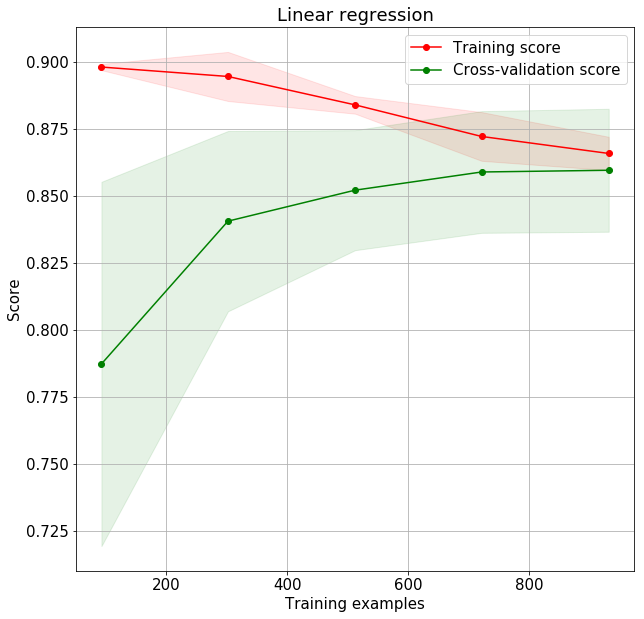

In [37]:
plot_learning_curve(X=train_x, y = train_y, estimator=lr, cv=5, title="Linear regression")

### Xgboost <a name='xgboost'></a>

Using xgboost and comparing without and with hyperopt

In [38]:
dtrain = xgb.DMatrix(train_x, label=train_y)
ddev = xgb.DMatrix(dev_x, label=dev_y)

In [39]:
param = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'base_score' : 0.5, 'booster' : 'gbtree', 
         'colsample_bylevel' : 1, 'colsample_bytree':1, 'learning_rate':0.1, 'max_delta_step':0,
         'min_child_weight':1, 'missing':None, 'n_estimators':100,
       'n_jobs':1, 'random_state':0,
       'reg_alpha':0, 'reg_lambda':1, 'scale_pos_weight':1,
       'silent':True, 'subsample':1, 'seed':42}
evallist = [(ddev, 'eval'), (dtrain, 'train')]
num_round=1000

In [40]:
bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=200)

[0]	eval-rmse:0.261618	train-rmse:0.256824
[200]	eval-rmse:0.043059	train-rmse:0.0065
[400]	eval-rmse:0.04297	train-rmse:0.00228
[600]	eval-rmse:0.042946	train-rmse:0.002029
[800]	eval-rmse:0.042946	train-rmse:0.002029
[999]	eval-rmse:0.042946	train-rmse:0.002029


In [41]:
xgbregr = xgb.XGBRegressor(seed=42)
xgbregr.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [42]:
pred = xgbregr.predict(dev_x)

In [43]:
pred2 = bst.predict(ddev)

Results without hyperopt - XGBRegressor and xgb.train compared

In [44]:
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=dev_y)))
print(np.sqrt(mean_squared_error(y_pred=pred2, y_true=dev_y)))

0.04131356630872501
0.04294602714136356


<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

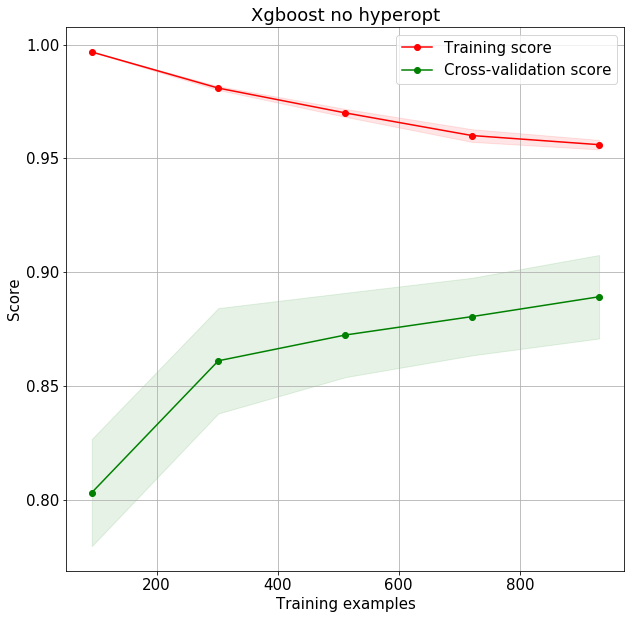

In [45]:
plot_learning_curve(X=train_x, y = train_y, estimator=xgbregr, cv=5, title="Xgboost no hyperopt")

Defining objective function and range for some parametrs to be used in hyperopt

In [46]:
def objective(space):
    print(space)
    clf = xgb.XGBRegressor(n_estimators =1000,colsample_bytree=space['colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'])

    eval_set  = [( train_x, train_y), ( dev_x, dev_y)]

    clf.fit(train_x, train_y,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(dev_x)
    mse_scr = mean_squared_error(dev_y, pred)
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }


space ={'max_depth': hp.quniform("x_max_depth", 1, 13, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.4,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1),
        'colsample_bylevel': hp.uniform('x_colsample_bylevel',0.4,1),
        'colsample_bynode' : hp.uniform('x_colsample_bynode',0.4,1),
        'reg_alpha': hp.uniform('x_reg_alpha',0,1)
        
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1000,
            trials=trials)

{'colsample_bylevel': 0.7931620467689906, 'colsample_bynode': 0.5359883008545572, 'colsample_bytree': 0.9780323386453506, 'gamma': 0.49124193646937114, 'max_depth': 10.0, 'min_child_weight': 10.0, 'reg_alpha': 0.6453582329416467, 'reg_lambda': 0.8238484935348048, 'subsample': 0.7416610091523299}
{'colsample_bylevel': 0.6751584197748934, 'colsample_bynode': 0.9921293706299538, 'colsample_bytree': 0.8745880719266845, 'gamma': 0.3829440899129779, 'max_depth': 3.0, 'min_child_weight': 9.0, 'reg_alpha': 0.019530024823819048, 'reg_lambda': 0.18046880900663498, 'subsample': 0.9397684990220927}
{'colsample_bylevel': 0.9476332519803589, 'colsample_bynode': 0.6524421392329712, 'colsample_bytree': 0.6300527007498862, 'gamma': 0.09714381581138887, 'max_depth': 4.0, 'min_child_weight': 6.0, 'reg_alpha': 0.4258199741569626, 'reg_lambda': 0.6714228021890787, 'subsample': 0.7383335551383501}
{'colsample_bylevel': 0.4780227329849433, 'colsample_bynode': 0.4109246364116485, 'colsample_bytree': 0.7104562

{'colsample_bylevel': 0.6324576515208536, 'colsample_bynode': 0.5303946925834332, 'colsample_bytree': 0.7675659467744178, 'gamma': 0.23939528892637574, 'max_depth': 3.0, 'min_child_weight': 10.0, 'reg_alpha': 0.3191301031910906, 'reg_lambda': 0.8966969767444787, 'subsample': 0.9381953694590421}
{'colsample_bylevel': 0.7737199403703293, 'colsample_bynode': 0.6693432568037982, 'colsample_bytree': 0.6512025724710024, 'gamma': 0.10973561694776995, 'max_depth': 3.0, 'min_child_weight': 9.0, 'reg_alpha': 0.17552877837452036, 'reg_lambda': 0.4396878713031004, 'subsample': 0.9248936155803978}
{'colsample_bylevel': 0.6806163707731625, 'colsample_bynode': 0.6251517932263713, 'colsample_bytree': 0.4930573220743966, 'gamma': 0.06736562108642376, 'max_depth': 10.0, 'min_child_weight': 8.0, 'reg_alpha': 0.3949727524264691, 'reg_lambda': 0.5832753828537219, 'subsample': 0.8576088876669461}
{'colsample_bylevel': 0.843790877328813, 'colsample_bynode': 0.7033879128772837, 'colsample_bytree': 0.433263441

{'colsample_bylevel': 0.6968987417652516, 'colsample_bynode': 0.8206817157697505, 'colsample_bytree': 0.7928685465025397, 'gamma': 0.13105568608587786, 'max_depth': 7.0, 'min_child_weight': 7.0, 'reg_alpha': 0.8432817310190212, 'reg_lambda': 0.5097164045180622, 'subsample': 0.7742205415877884}
{'colsample_bylevel': 0.7367243675702414, 'colsample_bynode': 0.7856960634308375, 'colsample_bytree': 0.629001947866576, 'gamma': 0.21850244123572798, 'max_depth': 3.0, 'min_child_weight': 2.0, 'reg_alpha': 0.5711820935051801, 'reg_lambda': 0.6293045166391769, 'subsample': 0.93028740498116}
{'colsample_bylevel': 0.574404515819104, 'colsample_bynode': 0.8743025131919873, 'colsample_bytree': 0.5040276794249463, 'gamma': 0.41286706558172037, 'max_depth': 9.0, 'min_child_weight': 4.0, 'reg_alpha': 0.9051797884278902, 'reg_lambda': 0.39744688053109867, 'subsample': 0.9047137132738157}
{'colsample_bylevel': 0.7608876562265469, 'colsample_bynode': 0.5971418579801454, 'colsample_bytree': 0.46076227355772

{'colsample_bylevel': 0.9410620792820195, 'colsample_bynode': 0.8092170895720633, 'colsample_bytree': 0.9957596609543147, 'gamma': 0.10047512561715025, 'max_depth': 1.0, 'min_child_weight': 3.0, 'reg_alpha': 0.47900462215283934, 'reg_lambda': 0.6003123786999168, 'subsample': 0.9317285109950587}
{'colsample_bylevel': 0.9835548287564941, 'colsample_bynode': 0.7177884830644172, 'colsample_bytree': 0.4068611403890149, 'gamma': 0.2238817479559514, 'max_depth': 5.0, 'min_child_weight': 8.0, 'reg_alpha': 0.23403137114877567, 'reg_lambda': 0.7253327927696528, 'subsample': 0.8866849007900179}
{'colsample_bylevel': 0.424095741595603, 'colsample_bynode': 0.9874477106145434, 'colsample_bytree': 0.5567819832313123, 'gamma': 0.3212742198236906, 'max_depth': 4.0, 'min_child_weight': 3.0, 'reg_alpha': 0.19153716613920296, 'reg_lambda': 0.3022724013170625, 'subsample': 0.9540844307758953}
{'colsample_bylevel': 0.7074513769601614, 'colsample_bynode': 0.942943613054007, 'colsample_bytree': 0.502130374617

{'colsample_bylevel': 0.6587077331415626, 'colsample_bynode': 0.6471586641430227, 'colsample_bytree': 0.47930184950364646, 'gamma': 0.10223467760354876, 'max_depth': 4.0, 'min_child_weight': 8.0, 'reg_alpha': 0.49059165675942207, 'reg_lambda': 0.39222241832817534, 'subsample': 0.9262344896894348}
{'colsample_bylevel': 0.5298383522961092, 'colsample_bynode': 0.6634351255362517, 'colsample_bytree': 0.5681272075880658, 'gamma': 0.2838846423436743, 'max_depth': 12.0, 'min_child_weight': 9.0, 'reg_alpha': 0.3784099268541884, 'reg_lambda': 0.24278248965111904, 'subsample': 0.912669323233416}
{'colsample_bylevel': 0.7283219434476862, 'colsample_bynode': 0.5506589882678513, 'colsample_bytree': 0.6127391537982828, 'gamma': 0.3359908060757313, 'max_depth': 3.0, 'min_child_weight': 10.0, 'reg_alpha': 0.3365617397708849, 'reg_lambda': 0.42660034223024296, 'subsample': 0.9741831014532695}
{'colsample_bylevel': 0.48625290240536845, 'colsample_bynode': 0.5027449784462605, 'colsample_bytree': 0.654405

{'colsample_bylevel': 0.7647463664492248, 'colsample_bynode': 0.877902930113503, 'colsample_bytree': 0.4064956955866905, 'gamma': 0.008732207801987683, 'max_depth': 3.0, 'min_child_weight': 9.0, 'reg_alpha': 0.32856994215471763, 'reg_lambda': 0.9257392717414459, 'subsample': 0.9617626756656233}
{'colsample_bylevel': 0.8495653358680486, 'colsample_bynode': 0.9258276818134114, 'colsample_bytree': 0.482295331237153, 'gamma': 0.02710145402245115, 'max_depth': 2.0, 'min_child_weight': 9.0, 'reg_alpha': 0.04657732348623153, 'reg_lambda': 0.7276933278788762, 'subsample': 0.9413693814903904}
{'colsample_bylevel': 0.8207325161691493, 'colsample_bynode': 0.8266072439393833, 'colsample_bytree': 0.5249789466700546, 'gamma': 0.07974438459724859, 'max_depth': 1.0, 'min_child_weight': 10.0, 'reg_alpha': 0.12904471818544921, 'reg_lambda': 0.6273259148117819, 'subsample': 0.9922020096126706}
{'colsample_bylevel': 0.8654676350988176, 'colsample_bynode': 0.8522293352189769, 'colsample_bytree': 0.44294317

{'colsample_bylevel': 0.5933333999969481, 'colsample_bynode': 0.6304057137343333, 'colsample_bytree': 0.49614780088207394, 'gamma': 0.03778824707310907, 'max_depth': 4.0, 'min_child_weight': 8.0, 'reg_alpha': 0.5180595826663184, 'reg_lambda': 0.6094478379904666, 'subsample': 0.9412424168533376}
{'colsample_bylevel': 0.6316432643944783, 'colsample_bynode': 0.5352218484811353, 'colsample_bytree': 0.7464871480523946, 'gamma': 0.05826295936589646, 'max_depth': 9.0, 'min_child_weight': 7.0, 'reg_alpha': 0.43072118912022817, 'reg_lambda': 0.8676761420563261, 'subsample': 0.953847984240592}
{'colsample_bylevel': 0.4802039379758586, 'colsample_bynode': 0.5582781098494465, 'colsample_bytree': 0.7268291109233286, 'gamma': 0.08412294277634333, 'max_depth': 2.0, 'min_child_weight': 6.0, 'reg_alpha': 0.08553691838610072, 'reg_lambda': 0.018071002895267974, 'subsample': 0.911339259797985}
{'colsample_bylevel': 0.41241016361121224, 'colsample_bynode': 0.9727204751152093, 'colsample_bytree': 0.6778483

{'colsample_bylevel': 0.4013728535416458, 'colsample_bynode': 0.7425702870797711, 'colsample_bytree': 0.7846565786028344, 'gamma': 0.00025235248037287425, 'max_depth': 8.0, 'min_child_weight': 5.0, 'reg_alpha': 0.7294166256230872, 'reg_lambda': 0.17672972466215336, 'subsample': 0.920570401090639}
{'colsample_bylevel': 0.6813496180479631, 'colsample_bynode': 0.7223483927448427, 'colsample_bytree': 0.5599797044765656, 'gamma': 0.05041104399501153, 'max_depth': 3.0, 'min_child_weight': 10.0, 'reg_alpha': 0.518792173844172, 'reg_lambda': 0.14878020442406575, 'subsample': 0.909215889964542}
{'colsample_bylevel': 0.6224431945188876, 'colsample_bynode': 0.6331142559226224, 'colsample_bytree': 0.7426036440657033, 'gamma': 0.11465439177044595, 'max_depth': 2.0, 'min_child_weight': 9.0, 'reg_alpha': 0.6669317931895222, 'reg_lambda': 0.3246760297601531, 'subsample': 0.9500807162764462}
{'colsample_bylevel': 0.8054237533773265, 'colsample_bynode': 0.6506440463082067, 'colsample_bytree': 0.65195925

{'colsample_bylevel': 0.9564986250873987, 'colsample_bynode': 0.40294175853691055, 'colsample_bytree': 0.910071727964242, 'gamma': 0.14799867645362058, 'max_depth': 8.0, 'min_child_weight': 4.0, 'reg_alpha': 0.8916499358502719, 'reg_lambda': 0.11719580328630032, 'subsample': 0.8657078026229444}
{'colsample_bylevel': 0.8865288207104928, 'colsample_bynode': 0.4471642611493717, 'colsample_bytree': 0.954643449136918, 'gamma': 0.11992056886547228, 'max_depth': 6.0, 'min_child_weight': 5.0, 'reg_alpha': 0.8063115479940222, 'reg_lambda': 0.0005044533523130557, 'subsample': 0.8896259729400724}
{'colsample_bylevel': 0.9803511400087379, 'colsample_bynode': 0.4247982116743827, 'colsample_bytree': 0.8398037943683472, 'gamma': 0.05696830466063123, 'max_depth': 9.0, 'min_child_weight': 3.0, 'reg_alpha': 0.8651369813795645, 'reg_lambda': 0.07286792450130991, 'subsample': 0.8173337809318657}
{'colsample_bylevel': 0.8582339841056604, 'colsample_bynode': 0.4753731331443395, 'colsample_bytree': 0.8250458

{'colsample_bylevel': 0.48371851012208145, 'colsample_bynode': 0.49440062191678547, 'colsample_bytree': 0.9412239026942341, 'gamma': 0.06823595165961363, 'max_depth': 7.0, 'min_child_weight': 6.0, 'reg_alpha': 0.6660834630193317, 'reg_lambda': 0.13149156469807122, 'subsample': 0.8815506279484481}
{'colsample_bylevel': 0.4230487828227025, 'colsample_bynode': 0.4748043293413217, 'colsample_bytree': 0.9156978563341611, 'gamma': 0.030891461597305048, 'max_depth': 6.0, 'min_child_weight': 5.0, 'reg_alpha': 0.9585241794224464, 'reg_lambda': 0.1804063984647543, 'subsample': 0.9328235797719256}
{'colsample_bylevel': 0.44788931535269194, 'colsample_bynode': 0.4387357083561203, 'colsample_bytree': 0.7865428642628086, 'gamma': 0.09333256480374501, 'max_depth': 4.0, 'min_child_weight': 4.0, 'reg_alpha': 0.7785562124251405, 'reg_lambda': 0.08923017207855934, 'subsample': 0.901432701595739}
{'colsample_bylevel': 0.4961442698580012, 'colsample_bynode': 0.4156576605754743, 'colsample_bytree': 0.966080

{'colsample_bylevel': 0.5395422787533506, 'colsample_bynode': 0.40068718660041275, 'colsample_bytree': 0.718477273933226, 'gamma': 0.011594543329783486, 'max_depth': 8.0, 'min_child_weight': 3.0, 'reg_alpha': 0.8801596086283207, 'reg_lambda': 0.023054243113351247, 'subsample': 0.8997678150394474}
{'colsample_bylevel': 0.5820824301258478, 'colsample_bynode': 0.4188410998541499, 'colsample_bytree': 0.6783440867314714, 'gamma': 0.02816335795504795, 'max_depth': 7.0, 'min_child_weight': 4.0, 'reg_alpha': 0.8253781004748759, 'reg_lambda': 0.09365021633775332, 'subsample': 0.9291032172292636}
{'colsample_bylevel': 0.6241915052267284, 'colsample_bynode': 0.45736602435402207, 'colsample_bytree': 0.9426518144535833, 'gamma': 0.06078245425781292, 'max_depth': 6.0, 'min_child_weight': 5.0, 'reg_alpha': 0.7790878841201315, 'reg_lambda': 0.06417700665019296, 'subsample': 0.9221542144738821}
{'colsample_bylevel': 0.524454740765675, 'colsample_bynode': 0.4332773883616943, 'colsample_bytree': 0.999555

{'colsample_bylevel': 0.5113952977137421, 'colsample_bynode': 0.42376888973552856, 'colsample_bytree': 0.8034441928158754, 'gamma': 0.049013035020090495, 'max_depth': 13.0, 'min_child_weight': 6.0, 'reg_alpha': 0.7688469657765453, 'reg_lambda': 0.06423647494397335, 'subsample': 0.9233706387702902}
{'colsample_bylevel': 0.431866885436901, 'colsample_bynode': 0.48152690208067295, 'colsample_bytree': 0.8022270635624381, 'gamma': 0.15162897156924307, 'max_depth': 12.0, 'min_child_weight': 5.0, 'reg_alpha': 0.6400302361721216, 'reg_lambda': 0.24196731819041925, 'subsample': 0.8777388928878087}
{'colsample_bylevel': 0.5074663161881774, 'colsample_bynode': 0.44828121435722157, 'colsample_bytree': 0.7921454217383637, 'gamma': 0.09287862436357405, 'max_depth': 13.0, 'min_child_weight': 4.0, 'reg_alpha': 0.6129802170632591, 'reg_lambda': 0.37078702305215594, 'subsample': 0.8076141341726107}
{'colsample_bylevel': 0.5637180426002784, 'colsample_bynode': 0.5727590960330777, 'colsample_bytree': 0.76

{'colsample_bylevel': 0.5872412655961065, 'colsample_bynode': 0.4719682505580603, 'colsample_bytree': 0.8825874412216324, 'gamma': 0.11662212427156966, 'max_depth': 8.0, 'min_child_weight': 7.0, 'reg_alpha': 0.955239162192673, 'reg_lambda': 0.2625823770347014, 'subsample': 0.9108516921858669}
{'colsample_bylevel': 0.6901547549494658, 'colsample_bynode': 0.5977730675952072, 'colsample_bytree': 0.8294132299848989, 'gamma': 0.039854784881712915, 'max_depth': 3.0, 'min_child_weight': 5.0, 'reg_alpha': 0.5882530960425147, 'reg_lambda': 0.07860986864618201, 'subsample': 0.9378813737568826}
{'colsample_bylevel': 0.9714820140687157, 'colsample_bynode': 0.4977622853201046, 'colsample_bytree': 0.9824928038829434, 'gamma': 0.2198079236647482, 'max_depth': 7.0, 'min_child_weight': 6.0, 'reg_alpha': 0.7479682535776845, 'reg_lambda': 0.18963100936335486, 'subsample': 0.9568928895125087}
{'colsample_bylevel': 0.43232173311441235, 'colsample_bynode': 0.5200739655412733, 'colsample_bytree': 0.776049838

{'colsample_bylevel': 0.9975057407267093, 'colsample_bynode': 0.49663188387666035, 'colsample_bytree': 0.6664584321916106, 'gamma': 0.05125061229508822, 'max_depth': 9.0, 'min_child_weight': 7.0, 'reg_alpha': 0.38540248712629305, 'reg_lambda': 0.02131353098257681, 'subsample': 0.9839730821356222}
{'colsample_bylevel': 0.6352361438652325, 'colsample_bynode': 0.48259137219862974, 'colsample_bytree': 0.7816533815432991, 'gamma': 0.0014761718931059996, 'max_depth': 1.0, 'min_child_weight': 6.0, 'reg_alpha': 0.37018977138182263, 'reg_lambda': 0.0029064268885019007, 'subsample': 0.9694928793657471}
{'colsample_bylevel': 0.7353562693767862, 'colsample_bynode': 0.5283525816221968, 'colsample_bytree': 0.6886018936323804, 'gamma': 0.0180553136068453, 'max_depth': 10.0, 'min_child_weight': 7.0, 'reg_alpha': 0.276449577492876, 'reg_lambda': 0.053213535024859676, 'subsample': 0.9890925511142863}
{'colsample_bylevel': 0.6597763418236346, 'colsample_bynode': 0.5111585698254979, 'colsample_bytree': 0.

{'colsample_bylevel': 0.7031447054210592, 'colsample_bynode': 0.46961275929153296, 'colsample_bytree': 0.627968119419276, 'gamma': 0.009054326071083363, 'max_depth': 4.0, 'min_child_weight': 6.0, 'reg_alpha': 0.5039872428844967, 'reg_lambda': 0.23577678992454382, 'subsample': 0.9625579607572117}
{'colsample_bylevel': 0.6771123816939675, 'colsample_bynode': 0.44103639737818295, 'colsample_bytree': 0.8598546284587034, 'gamma': 0.0008655530889858038, 'max_depth': 2.0, 'min_child_weight': 5.0, 'reg_alpha': 0.19921771269786598, 'reg_lambda': 0.08259743136536221, 'subsample': 0.9286286223421477}
{'colsample_bylevel': 0.6129939000329395, 'colsample_bynode': 0.4555616223162124, 'colsample_bytree': 0.7731466633659033, 'gamma': 0.026985236674342276, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 0.2615453917574468, 'reg_lambda': 0.2057844814476995, 'subsample': 0.9415643690793303}
{'colsample_bylevel': 0.5608928565420566, 'colsample_bynode': 0.5312236434085739, 'colsample_bytree': 0.793

{'colsample_bylevel': 0.7272545294944526, 'colsample_bynode': 0.5213355318161217, 'colsample_bytree': 0.6273326723764175, 'gamma': 0.002158618663500103, 'max_depth': 3.0, 'min_child_weight': 7.0, 'reg_alpha': 0.22550617161314696, 'reg_lambda': 0.09857989910134321, 'subsample': 0.9444181641055313}
{'colsample_bylevel': 0.5444170124832574, 'colsample_bynode': 0.5045799313901137, 'colsample_bytree': 0.6474532427697924, 'gamma': 0.29765278352761704, 'max_depth': 4.0, 'min_child_weight': 7.0, 'reg_alpha': 0.24467628881767386, 'reg_lambda': 0.049746913230268114, 'subsample': 0.984776163802464}
{'colsample_bylevel': 0.5900177007429698, 'colsample_bynode': 0.5651891397519541, 'colsample_bytree': 0.7269654776147607, 'gamma': 0.07095408870777005, 'max_depth': 3.0, 'min_child_weight': 7.0, 'reg_alpha': 0.29261966658071314, 'reg_lambda': 0.036068311032682016, 'subsample': 0.9703513123940256}
{'colsample_bylevel': 0.6236504630437708, 'colsample_bynode': 0.532452031590426, 'colsample_bytree': 0.6089

{'colsample_bylevel': 0.8557876267171332, 'colsample_bynode': 0.6407037054632443, 'colsample_bytree': 0.7974440017628518, 'gamma': 0.265692863914479, 'max_depth': 3.0, 'min_child_weight': 8.0, 'reg_alpha': 0.75191329900813, 'reg_lambda': 0.12026052180012492, 'subsample': 0.8812095547687326}
{'colsample_bylevel': 0.45682642003860097, 'colsample_bynode': 0.5090849248636148, 'colsample_bytree': 0.733083474438271, 'gamma': 0.07397012669918353, 'max_depth': 9.0, 'min_child_weight': 6.0, 'reg_alpha': 0.9142110376037609, 'reg_lambda': 0.24826513906984893, 'subsample': 0.9249303834924733}
{'colsample_bylevel': 0.7182140946403274, 'colsample_bynode': 0.5808018077382262, 'colsample_bytree': 0.7575097347232648, 'gamma': 0.011124239457906953, 'max_depth': 2.0, 'min_child_weight': 7.0, 'reg_alpha': 0.8851769326146526, 'reg_lambda': 0.07531590948342522, 'subsample': 0.9426037624209432}
{'colsample_bylevel': 0.6386255413842319, 'colsample_bynode': 0.42382178043784147, 'colsample_bytree': 0.8729095624

{'colsample_bylevel': 0.9991448065759418, 'colsample_bynode': 0.5381495456672734, 'colsample_bytree': 0.987628036448154, 'gamma': 0.07510643342748904, 'max_depth': 10.0, 'min_child_weight': 5.0, 'reg_alpha': 0.8056191739982753, 'reg_lambda': 0.09339523538493992, 'subsample': 0.9938576917926745}
{'colsample_bylevel': 0.5667087168147595, 'colsample_bynode': 0.7084204637979636, 'colsample_bytree': 0.7686388145408335, 'gamma': 0.022911298847864, 'max_depth': 6.0, 'min_child_weight': 8.0, 'reg_alpha': 0.1394250937402667, 'reg_lambda': 0.027904594360069188, 'subsample': 0.9401161811944234}
{'colsample_bylevel': 0.6107236213286144, 'colsample_bynode': 0.44614874863922, 'colsample_bytree': 0.8810965560129891, 'gamma': 0.041776534818764095, 'max_depth': 4.0, 'min_child_weight': 7.0, 'reg_alpha': 0.3225647548470508, 'reg_lambda': 0.1424309412733419, 'subsample': 0.9449644988022865}
{'colsample_bylevel': 0.7604836696630302, 'colsample_bynode': 0.6128676046581479, 'colsample_bytree': 0.78218266732

{'colsample_bylevel': 0.9664471722398358, 'colsample_bynode': 0.47436447410201393, 'colsample_bytree': 0.7580942063281643, 'gamma': 0.028949863108603435, 'max_depth': 1.0, 'min_child_weight': 7.0, 'reg_alpha': 0.10258769049738303, 'reg_lambda': 0.43460632464825966, 'subsample': 0.9758289865237703}
{'colsample_bylevel': 0.7051159650560803, 'colsample_bynode': 0.6706858921596426, 'colsample_bytree': 0.7904792647506058, 'gamma': 0.0572558413693957, 'max_depth': 7.0, 'min_child_weight': 5.0, 'reg_alpha': 0.05702039406917059, 'reg_lambda': 0.2935035129489957, 'subsample': 0.9331869652148223}
{'colsample_bylevel': 0.9530441429955585, 'colsample_bynode': 0.42236268906246505, 'colsample_bytree': 0.9249025391576589, 'gamma': 0.3121878369476696, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 0.7135741218360414, 'reg_lambda': 0.16902667637226024, 'subsample': 0.954729399927804}
{'colsample_bylevel': 0.644331773490511, 'colsample_bynode': 0.4922080399456916, 'colsample_bytree': 0.81649211

{'colsample_bylevel': 0.7116251922993386, 'colsample_bynode': 0.46636737695172126, 'colsample_bytree': 0.7781663016448795, 'gamma': 0.038802935916204644, 'max_depth': 3.0, 'min_child_weight': 7.0, 'reg_alpha': 0.2898885346222905, 'reg_lambda': 0.07327309607871833, 'subsample': 0.9073928113712071}
{'colsample_bylevel': 0.7835275396261757, 'colsample_bynode': 0.5373249015283531, 'colsample_bytree': 0.8788381402442144, 'gamma': 0.02141397682957834, 'max_depth': 4.0, 'min_child_weight': 8.0, 'reg_alpha': 0.4519549951294676, 'reg_lambda': 0.16286657287991785, 'subsample': 0.9513637531116593}
{'colsample_bylevel': 0.5872095085826665, 'colsample_bynode': 0.44749402562355167, 'colsample_bytree': 0.7944134487332744, 'gamma': 0.08631805040793827, 'max_depth': 10.0, 'min_child_weight': 5.0, 'reg_alpha': 0.41576020012684417, 'reg_lambda': 0.19541728336477165, 'subsample': 0.9372700820399701}
{'colsample_bylevel': 0.4967724599990543, 'colsample_bynode': 0.5960983415196472, 'colsample_bytree': 0.890

{'colsample_bylevel': 0.8500327770164601, 'colsample_bynode': 0.5254108087371769, 'colsample_bytree': 0.7982645712834483, 'gamma': 0.018504765220655826, 'max_depth': 4.0, 'min_child_weight': 5.0, 'reg_alpha': 0.7460065705280707, 'reg_lambda': 0.08611073683065176, 'subsample': 0.9403111234993978}
{'colsample_bylevel': 0.8976132909877106, 'colsample_bynode': 0.500959322046167, 'colsample_bytree': 0.7738968559834176, 'gamma': 0.04009074036805771, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 0.688359537669412, 'reg_lambda': 0.09929599619887693, 'subsample': 0.9508419910126432}
{'colsample_bylevel': 0.9244045276661945, 'colsample_bynode': 0.4829766298052318, 'colsample_bytree': 0.8010160746537851, 'gamma': 0.026952158060017016, 'max_depth': 3.0, 'min_child_weight': 5.0, 'reg_alpha': 0.7421375915710079, 'reg_lambda': 0.12087310316230662, 'subsample': 0.9451443121578572}
{'colsample_bylevel': 0.7910813761676316, 'colsample_bynode': 0.5376279367005402, 'colsample_bytree': 0.78327041

{'colsample_bylevel': 0.7598766428184103, 'colsample_bynode': 0.5239025880257895, 'colsample_bytree': 0.7386699786368998, 'gamma': 0.13658227820354427, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 0.6738086878665739, 'reg_lambda': 0.2641099395025422, 'subsample': 0.919075472309634}
{'colsample_bylevel': 0.8254031171078171, 'colsample_bynode': 0.47321328708927274, 'colsample_bytree': 0.7729466151749418, 'gamma': 0.0883705151857388, 'max_depth': 4.0, 'min_child_weight': 8.0, 'reg_alpha': 0.7216016672372306, 'reg_lambda': 0.03588403869565358, 'subsample': 0.9547976918055727}
{'colsample_bylevel': 0.7933415400774164, 'colsample_bynode': 0.5864249553948953, 'colsample_bytree': 0.7333878628978809, 'gamma': 0.04163179900187467, 'max_depth': 5.0, 'min_child_weight': 7.0, 'reg_alpha': 0.6227757799298009, 'reg_lambda': 0.059709067299952234, 'subsample': 0.9702462870789421}
{'colsample_bylevel': 0.7444293613498559, 'colsample_bynode': 0.5061371861567093, 'colsample_bytree': 0.702983354

{'colsample_bylevel': 0.7744601287370554, 'colsample_bynode': 0.6689931864877033, 'colsample_bytree': 0.751348261577162, 'gamma': 0.04036955719889407, 'max_depth': 1.0, 'min_child_weight': 7.0, 'reg_alpha': 0.6484455014465715, 'reg_lambda': 0.10834428028914578, 'subsample': 0.9474986925296885}
{'colsample_bylevel': 0.7830896968857936, 'colsample_bynode': 0.5968062027873585, 'colsample_bytree': 0.708822248456663, 'gamma': 0.017849654133029785, 'max_depth': 2.0, 'min_child_weight': 7.0, 'reg_alpha': 0.6853195486083421, 'reg_lambda': 0.15701381889514163, 'subsample': 0.9368298551387015}
{'colsample_bylevel': 0.7649395965920737, 'colsample_bynode': 0.6156062665627877, 'colsample_bytree': 0.6217242937107086, 'gamma': 0.3623586100704861, 'max_depth': 4.0, 'min_child_weight': 8.0, 'reg_alpha': 0.5902335884059311, 'reg_lambda': 0.04751937707757453, 'subsample': 0.994321163046552}
{'colsample_bylevel': 0.7148022799079948, 'colsample_bynode': 0.5651745580132673, 'colsample_bytree': 0.73200266629

{'colsample_bylevel': 0.6840627348328628, 'colsample_bynode': 0.5597854992056044, 'colsample_bytree': 0.7780617208707189, 'gamma': 0.03884567817573648, 'max_depth': 1.0, 'min_child_weight': 6.0, 'reg_alpha': 0.721858210407986, 'reg_lambda': 0.1352351452750542, 'subsample': 0.9561156467409737}
{'colsample_bylevel': 0.595947324009502, 'colsample_bynode': 0.5150590218526172, 'colsample_bytree': 0.6903599295801627, 'gamma': 0.019503372291886964, 'max_depth': 4.0, 'min_child_weight': 8.0, 'reg_alpha': 0.7909424513108766, 'reg_lambda': 0.1575463585374992, 'subsample': 0.7660679435966303}
{'colsample_bylevel': 0.6485586511449273, 'colsample_bynode': 0.622859530580122, 'colsample_bytree': 0.8382835662552091, 'gamma': 0.049603484804426876, 'max_depth': 2.0, 'min_child_weight': 7.0, 'reg_alpha': 0.3924751191941041, 'reg_lambda': 0.20107021993544544, 'subsample': 0.8988120602267473}
{'colsample_bylevel': 0.5803828020233069, 'colsample_bynode': 0.5464133272594301, 'colsample_bytree': 0.76515732483

{'colsample_bylevel': 0.5990764688696862, 'colsample_bynode': 0.49211194420204146, 'colsample_bytree': 0.7689741846457628, 'gamma': 0.0887676610176608, 'max_depth': 5.0, 'min_child_weight': 7.0, 'reg_alpha': 0.7816871184591827, 'reg_lambda': 0.25215550524942665, 'subsample': 0.9077872610445685}
{'colsample_bylevel': 0.6655718804650788, 'colsample_bynode': 0.5924518103709154, 'colsample_bytree': 0.6841899232330686, 'gamma': 0.02787777052357229, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 0.5812736288693878, 'reg_lambda': 0.4116610532503887, 'subsample': 0.9772907572796845}
{'colsample_bylevel': 0.6262068214043532, 'colsample_bynode': 0.550183358439672, 'colsample_bytree': 0.7503482471195311, 'gamma': 0.020620593667408663, 'max_depth': 4.0, 'min_child_weight': 7.0, 'reg_alpha': 0.668363197377015, 'reg_lambda': 0.0002722830777212304, 'subsample': 0.9528099484958794}
{'colsample_bylevel': 0.8108899229315284, 'colsample_bynode': 0.5164422950696038, 'colsample_bytree': 0.60850354

{'colsample_bylevel': 0.8279931207540938, 'colsample_bynode': 0.4396936140567755, 'colsample_bytree': 0.7168857812705879, 'gamma': 0.0017159551292717807, 'max_depth': 4.0, 'min_child_weight': 7.0, 'reg_alpha': 0.10468386876682342, 'reg_lambda': 0.36493063350690425, 'subsample': 0.9139783684118863}
{'colsample_bylevel': 0.9881136306162526, 'colsample_bynode': 0.4270225876159906, 'colsample_bytree': 0.646464374341472, 'gamma': 0.014304683175301957, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 0.2880309212248415, 'reg_lambda': 0.3416826554822536, 'subsample': 0.9510874608292215}
{'colsample_bylevel': 0.8385078269857329, 'colsample_bynode': 0.4891500659841427, 'colsample_bytree': 0.5835913557624856, 'gamma': 0.02220461040055686, 'max_depth': 3.0, 'min_child_weight': 7.0, 'reg_alpha': 0.18744885564530872, 'reg_lambda': 0.2197677972250312, 'subsample': 0.9322797909416187}
{'colsample_bylevel': 0.9047047011956603, 'colsample_bynode': 0.5035056591962904, 'colsample_bytree': 0.687072

{'colsample_bylevel': 0.4925717569796204, 'colsample_bynode': 0.42750324400014883, 'colsample_bytree': 0.7848548979389597, 'gamma': 0.0832087572927388, 'max_depth': 5.0, 'min_child_weight': 8.0, 'reg_alpha': 0.331982321088822, 'reg_lambda': 0.49738168760169194, 'subsample': 0.9008990856900805}
{'colsample_bylevel': 0.4537768044752491, 'colsample_bynode': 0.47030652427782615, 'colsample_bytree': 0.8665711370594859, 'gamma': 0.27881154127690977, 'max_depth': 3.0, 'min_child_weight': 7.0, 'reg_alpha': 0.2983012485397413, 'reg_lambda': 0.5285448022835847, 'subsample': 0.9998218615806979}
{'colsample_bylevel': 0.8584375969363016, 'colsample_bynode': 0.43817980992767613, 'colsample_bytree': 0.741461821038791, 'gamma': 0.07239185358468948, 'max_depth': 4.0, 'min_child_weight': 5.0, 'reg_alpha': 0.43727034626824335, 'reg_lambda': 0.6425644376616069, 'subsample': 0.9250976102759176}
{'colsample_bylevel': 0.8335938876371556, 'colsample_bynode': 0.4544275970003558, 'colsample_bytree': 0.756814848

{'colsample_bylevel': 0.852692030099772, 'colsample_bynode': 0.4386473008737773, 'colsample_bytree': 0.8382215962487088, 'gamma': 0.07912795993275948, 'max_depth': 4.0, 'min_child_weight': 6.0, 'reg_alpha': 0.46028170095795584, 'reg_lambda': 0.5034170920729084, 'subsample': 0.9209954940925804}
{'colsample_bylevel': 0.8149910051893965, 'colsample_bynode': 0.5607276233237686, 'colsample_bytree': 0.72627327145862, 'gamma': 0.009649414647798848, 'max_depth': 2.0, 'min_child_weight': 8.0, 'reg_alpha': 0.2962560273513559, 'reg_lambda': 0.4022609097524582, 'subsample': 0.8438002206762355}
{'colsample_bylevel': 0.8820574102862364, 'colsample_bynode': 0.4917018404980627, 'colsample_bytree': 0.7469049459421225, 'gamma': 0.0005149755034140446, 'max_depth': 4.0, 'min_child_weight': 5.0, 'reg_alpha': 0.17845831288384115, 'reg_lambda': 0.6331771645532135, 'subsample': 0.9529954954965812}
{'colsample_bylevel': 0.5612562979644784, 'colsample_bynode': 0.5431128325565943, 'colsample_bytree': 0.760516796

{'colsample_bylevel': 0.5183824017741023, 'colsample_bynode': 0.41229716878929995, 'colsample_bytree': 0.7316733580773084, 'gamma': 0.07054433991397682, 'max_depth': 2.0, 'min_child_weight': 6.0, 'reg_alpha': 0.48929015794118313, 'reg_lambda': 0.6578832148222481, 'subsample': 0.9516461305315891}
{'colsample_bylevel': 0.49158718720281186, 'colsample_bynode': 0.48122571862109453, 'colsample_bytree': 0.7094117270281559, 'gamma': 0.04946836918788053, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 0.45839985764820684, 'reg_lambda': 0.703538966654282, 'subsample': 0.9564553021721787}
{'colsample_bylevel': 0.506208248110905, 'colsample_bynode': 0.4210224452538224, 'colsample_bytree': 0.688474920285077, 'gamma': 0.061323217351799304, 'max_depth': 4.0, 'min_child_weight': 5.0, 'reg_alpha': 0.43756939141265355, 'reg_lambda': 0.662772143006849, 'subsample': 0.9829184997258426}
{'colsample_bylevel': 0.47904656614092406, 'colsample_bynode': 0.4342031682185684, 'colsample_bytree': 0.7194509

{'colsample_bylevel': 0.5474432748797736, 'colsample_bynode': 0.47852171818647926, 'colsample_bytree': 0.8001145660435223, 'gamma': 0.041725368854909246, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 0.3041041005224649, 'reg_lambda': 0.6285362085972429, 'subsample': 0.9358019580145078}
{'colsample_bylevel': 0.57097038537388, 'colsample_bynode': 0.41083396098131436, 'colsample_bytree': 0.7560074590070462, 'gamma': 0.025676736214313545, 'max_depth': 4.0, 'min_child_weight': 5.0, 'reg_alpha': 0.7408126048119537, 'reg_lambda': 0.891885092601759, 'subsample': 0.9576763814377403}
{'colsample_bylevel': 0.5303525445426926, 'colsample_bynode': 0.50340240046325, 'colsample_bytree': 0.7294967731035995, 'gamma': 0.0005910629269384248, 'max_depth': 2.0, 'min_child_weight': 7.0, 'reg_alpha': 0.46828892165778674, 'reg_lambda': 0.6607952117222157, 'subsample': 0.9998459593776476}
{'colsample_bylevel': 0.4342774431975346, 'colsample_bynode': 0.438448579969764, 'colsample_bytree': 0.7821933317

{'colsample_bylevel': 0.4745685997649137, 'colsample_bynode': 0.5195132059522478, 'colsample_bytree': 0.7476211136968282, 'gamma': 0.06454209725599988, 'max_depth': 2.0, 'min_child_weight': 6.0, 'reg_alpha': 0.30281630952005284, 'reg_lambda': 0.1282933999195706, 'subsample': 0.9260372300550638}
{'colsample_bylevel': 0.5209938776311034, 'colsample_bynode': 0.4525350385072319, 'colsample_bytree': 0.8261412351695819, 'gamma': 0.04173561845120795, 'max_depth': 4.0, 'min_child_weight': 7.0, 'reg_alpha': 0.417329994043262, 'reg_lambda': 0.6167572861944863, 'subsample': 0.9490794227554544}
{'colsample_bylevel': 0.45399555010715886, 'colsample_bynode': 0.4994796572194254, 'colsample_bytree': 0.7967534091702582, 'gamma': 0.0804970809607563, 'max_depth': 3.0, 'min_child_weight': 6.0, 'reg_alpha': 0.35543766338837895, 'reg_lambda': 0.16483198545095054, 'subsample': 0.9715187692646998}
{'colsample_bylevel': 0.8920301071735414, 'colsample_bynode': 0.4431561662244746, 'colsample_bytree': 0.721984511

{'colsample_bylevel': 0.4147849202514564, 'colsample_bynode': 0.56864392652287, 'colsample_bytree': 0.6202080179677354, 'gamma': 0.020016195300511675, 'max_depth': 4.0, 'min_child_weight': 7.0, 'reg_alpha': 0.852780236169304, 'reg_lambda': 0.107123008166305, 'subsample': 0.9569787467546084}
{'colsample_bylevel': 0.40666133764697093, 'colsample_bynode': 0.5470440495638568, 'colsample_bytree': 0.5629543096027377, 'gamma': 0.007403836508799959, 'max_depth': 4.0, 'min_child_weight': 8.0, 'reg_alpha': 0.8960671727591852, 'reg_lambda': 0.08742156427627557, 'subsample': 0.9631929837976088}
{'colsample_bylevel': 0.42569184832612866, 'colsample_bynode': 0.5231546239522107, 'colsample_bytree': 0.6398023567666715, 'gamma': 0.02789892007313506, 'max_depth': 5.0, 'min_child_weight': 7.0, 'reg_alpha': 0.6896523582447633, 'reg_lambda': 0.21843236173242023, 'subsample': 0.9442401484851739}
{'colsample_bylevel': 0.4266957931920295, 'colsample_bynode': 0.494637924895835, 'colsample_bytree': 0.5437513769

{'colsample_bylevel': 0.8749592547952246, 'colsample_bynode': 0.5218156783839087, 'colsample_bytree': 0.6438725834641816, 'gamma': 0.02531487697443394, 'max_depth': 6.0, 'min_child_weight': 7.0, 'reg_alpha': 0.9112912542652684, 'reg_lambda': 0.14324492740180336, 'subsample': 0.9423806988324686}
{'colsample_bylevel': 0.8939459700781868, 'colsample_bynode': 0.5067971184346362, 'colsample_bytree': 0.6788981293342088, 'gamma': 0.053210757171302386, 'max_depth': 4.0, 'min_child_weight': 6.0, 'reg_alpha': 0.8626361199641385, 'reg_lambda': 0.26132864374633724, 'subsample': 0.994696065145777}
{'colsample_bylevel': 0.41769781039266163, 'colsample_bynode': 0.47140856876217474, 'colsample_bytree': 0.6140614738256788, 'gamma': 0.24248884337340332, 'max_depth': 3.0, 'min_child_weight': 7.0, 'reg_alpha': 0.650632121279653, 'reg_lambda': 0.18996424006520451, 'subsample': 0.9216695495399791}
{'colsample_bylevel': 0.46343054652227633, 'colsample_bynode': 0.48607645438468317, 'colsample_bytree': 0.59004

{'colsample_bylevel': 0.9468934011544591, 'colsample_bynode': 0.46470904073316865, 'colsample_bytree': 0.6782208736328347, 'gamma': 0.027905804749355622, 'max_depth': 5.0, 'min_child_weight': 9.0, 'reg_alpha': 0.593537858415242, 'reg_lambda': 0.02001632195165652, 'subsample': 0.9026096881791886}
{'colsample_bylevel': 0.9191219652947253, 'colsample_bynode': 0.4510947204437892, 'colsample_bytree': 0.687553363960039, 'gamma': 4.761635867707101e-05, 'max_depth': 3.0, 'min_child_weight': 8.0, 'reg_alpha': 0.5835269184390341, 'reg_lambda': 0.035202838061099306, 'subsample': 0.9109479185831563}
{'colsample_bylevel': 0.908571309226392, 'colsample_bynode': 0.42981143054360593, 'colsample_bytree': 0.6173449641158519, 'gamma': 0.00977302496186682, 'max_depth': 2.0, 'min_child_weight': 8.0, 'reg_alpha': 0.5933804047762686, 'reg_lambda': 0.03994828549829628, 'subsample': 0.8554264856085169}
{'colsample_bylevel': 0.9914577460556544, 'colsample_bynode': 0.43285846287996327, 'colsample_bytree': 0.6064

{'colsample_bylevel': 0.97792087263538, 'colsample_bynode': 0.4580721913830513, 'colsample_bytree': 0.5914514566778218, 'gamma': 0.02573516953843757, 'max_depth': 3.0, 'min_child_weight': 8.0, 'reg_alpha': 0.5036966417668634, 'reg_lambda': 0.029209588487061774, 'subsample': 0.9223895081645324}
{'colsample_bylevel': 0.9524909522996574, 'colsample_bynode': 0.9546852394416923, 'colsample_bytree': 0.7025405689912703, 'gamma': 0.05736170061749783, 'max_depth': 4.0, 'min_child_weight': 8.0, 'reg_alpha': 0.6069581012662919, 'reg_lambda': 6.728357330676449e-06, 'subsample': 0.9047310909372367}
{'colsample_bylevel': 0.9350408360117068, 'colsample_bynode': 0.4734664823007183, 'colsample_bytree': 0.6332324328245099, 'gamma': 0.0006133069584975497, 'max_depth': 2.0, 'min_child_weight': 8.0, 'reg_alpha': 0.624227572923946, 'reg_lambda': 0.06157432549994865, 'subsample': 0.9108351661136319}
{'colsample_bylevel': 0.9976496943891662, 'colsample_bynode': 0.40107234182417384, 'colsample_bytree': 0.67200

In [47]:
# The trials database now contains 100 entries, it can be saved/reloaded with pickle or another method
pickle.dump(trials, open("trials.pickle", "wb"))
trials = pickle.load(open("trials.pickle", "rb"))

# Perform an additional 100 evaluations
# Note that max_evals is set to 200 because 100 entries already exist in the database
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=200)

In [48]:
param = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'base_score' : 0.5, 'booster' : 'gbtree', 
         'colsample_bylevel' : 1, 'learning_rate':0.1, 'max_delta_step':0,
         'missing':None, 'n_estimators':100,
       'n_jobs':1, 'random_state':0,
       'reg_alpha':0, 'scale_pos_weight':1,
       'silent':True, 'subsample':1, 'seed':42, 'max_depth':int(best['x_max_depth']), 'gamma':best['x_gamma'],
        'reg_lambda':best['x_reg_lambda'],'subsample':best['x_subsample'], 
         'colsample_bytree':best['x_colsample_bytree'], 'min_child_weight':int(best['x_min_child'])}
evallist = [(ddev, 'eval'), (dtrain, 'train')]
num_round=1000

In [49]:
xgb_hyperopt = xgb.XGBRegressor(**param)

<module 'matplotlib.pyplot' from '/Users/lukaszbala/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

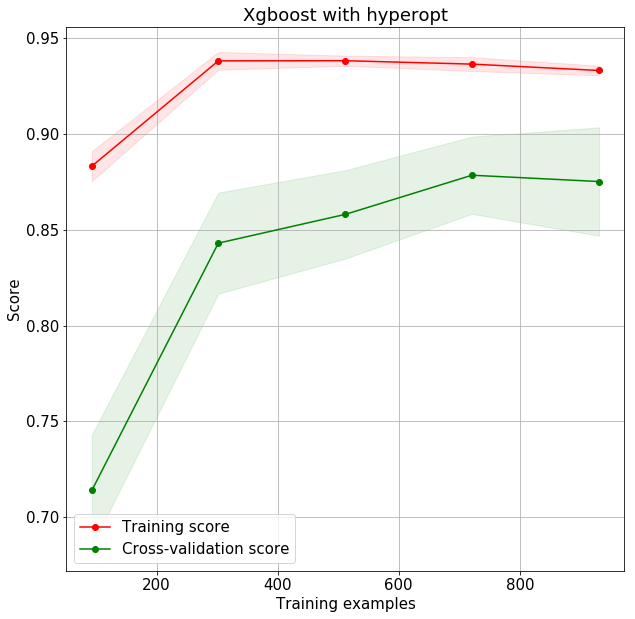

In [50]:
plot_learning_curve(X=train_x, y = train_y, estimator=xgb_hyperopt, cv=5, title="Xgboost with hyperopt")

In [51]:
xgb_hyperopt.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6442732885273748, eval_metric='rmse',
       gamma=0.025706745050976434, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=6, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.10634223905830964, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.9389139748185177)

In [52]:
print(np.sqrt(mean_squared_error(y_pred=xgb_hyperopt.predict(dev_x), y_true=dev_y)))

0.04276312503581445


It is surprising that the result is worse than the base XGBRegressor fit.
One should look into the dependence of results and obtained hyperparameters.
<br>
We are going to obtain dependency of loss vs hyperparameters by extracting these values
from "trials" object.

In [86]:
values = [key for key in list(trials)[0]['misc']['vals'].keys()]

loss_all = [x['result']['loss'] for x in list(trials)]
params_all = [[x['misc']['vals'][y][0] for x in list(trials)] for y in values]

In [130]:
params_hyperopt_df = pd.DataFrame([*params_all, loss_all]).T
params_hyperopt_df.columns = [*values, 'loss']

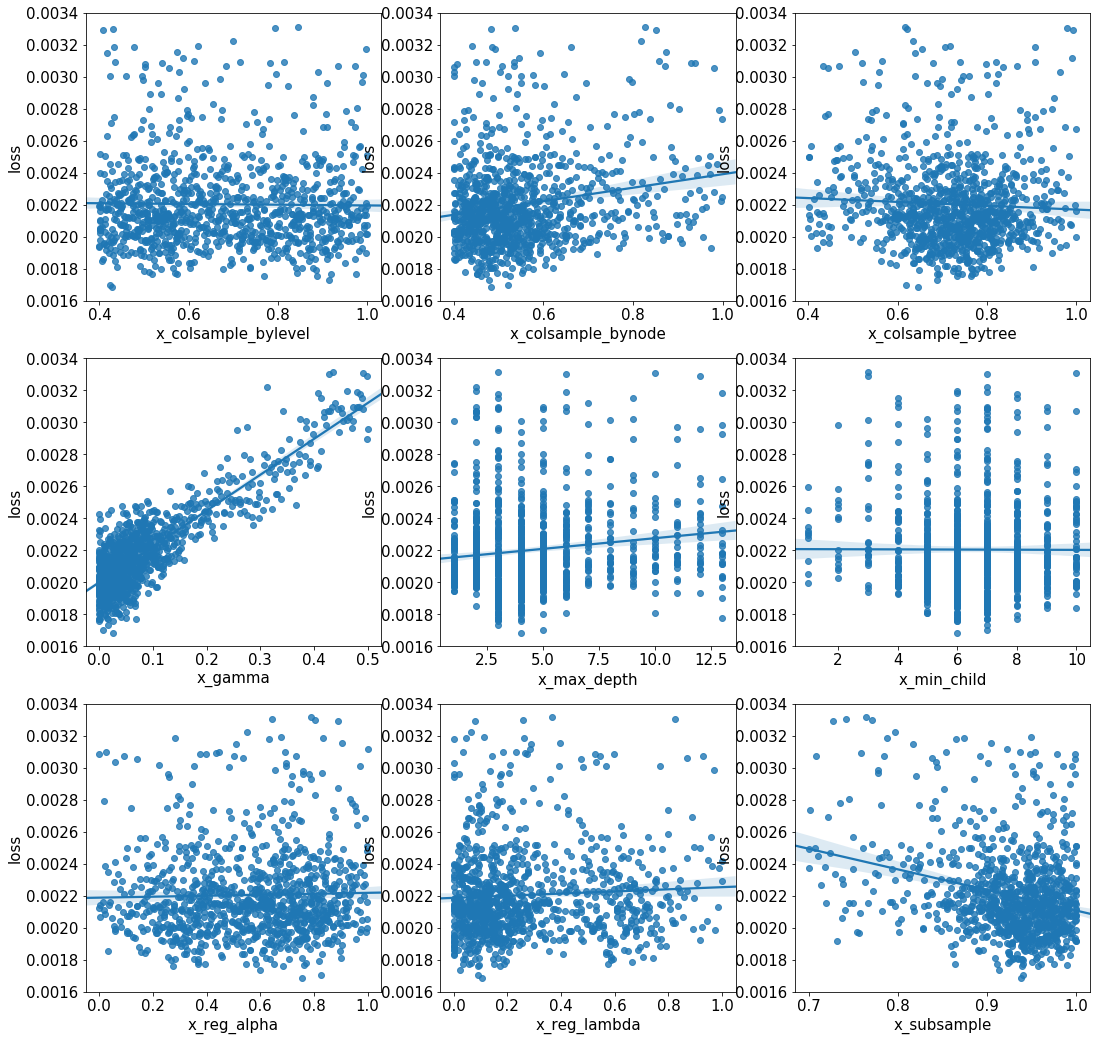

In [144]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(18,18))
axes = axes.flatten()
plot_type = 'regplot'
for idx, ax in enumerate(axes):
    ax.ticklabel_format(style='sci')
    plt.sca(ax)
    try:
        getattr(sns, plot_type)(x=values[idx], y = 'loss', data=params_hyperopt_df)
    except AtributeError:
        print("Try different type of plot")
        raise

One can see that we can obtain lower loss by either:
*  decreasing x_colsample_bynode
*  increasing x_subsample

The rest of the parameters either do not seem to reduce loss or they even increase it when changed from default ones (like x_gamma)